In [1]:
import os

from functools import reduce  # Import reduce

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter

from IPython.display import display
from IPython.display import clear_output
                                                                    
import seaborn as sns

import joblib

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from category_encoders import TargetEncoder

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from scipy.stats import mode

# Кластеры для районов
# Таргет трайнуть

In [2]:
from utils.util import check, valeraInfo, dump_ZV, undump_ZV, get_cols_containing
from utils.classes import DataFrameConverter, KNNModeImputer
from utils.outliers import count_values_above_threshold, count_values_below_threshold, remove_outliers_explicit, remove_outliers_iqr, remove_outliers_percentile
from utils.visualization import visualize_target_distribution
from utils.feature_engineering import aggregate_affordability_accessibility, calculate_weighted_build_count, calculate_weighted_material_score, create_accessibility_and_adequacy_features, drop_initial_features, drop_redundant_columns, drop_testing, improve_top_features, process_and_drop_cafe_price_columns, process_demographic_features, process_distance_features, feature_distance_weights, construction_weights, weighted_average_aggregation, material_weights, green_weights, prom_weights

check()

ZVC2345


In [3]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
np.set_printoptions(threshold=np.inf)  # For NumPy arrays

In [4]:
DATA_PATH = os.path.join("datasets", "Sber_housing_kaggle")
data_file = ["train.csv"]
macro_file = ["macro.csv"]

In [5]:
load_data = lambda path, files_names: (
    [pd.read_csv(os.path.join(path, file), parse_dates=["timestamp"]) for file in files_names]
)

In [6]:
[data] = load_data(DATA_PATH, data_file)
[macro] = load_data(DATA_PATH, macro_file)

In [7]:
print(macro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   timestamp                                   2484 non-null   datetime64[ns]
 1   oil_urals                                   2484 non-null   float64       
 2   gdp_quart                                   2394 non-null   float64       
 3   gdp_quart_growth                            2394 non-null   float64       
 4   cpi                                         2453 non-null   float64       
 5   ppi                                         2453 non-null   float64       
 6   gdp_deflator                                2119 non-null   float64       
 7   balance_trade                               2453 non-null   float64       
 8   balance_trade_growth                        2394 non-null   float64       
 9   usdrub 

In [8]:
data.head(1)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [9]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,99.900000,99.800000,99.600000,44.400000,95.700000,55.000000,99.900000,0.300000,74.200000,6.100000,5.870000,696.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.000000,99.400000,7872.848285,162.900000,NaN,NaN,NaN,690.000000,6221.000000,527.000000,0.410000,993.000000,NaN,NaN,63.030000,22825.000000,NaN
1,2010-01-02,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,175.150000,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,99.900000,99.800000,99.600000,44.400000,95.700000,55.000000,99.900000,0.300000,74.200000,6.100000,5.870000,696.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.000000,99.400000,7872.848285,162.900000,NaN,NaN,NaN,690.000000,6221.000000,527.000000,0.410000,993.000000,NaN,NaN,63.030000,22825.000000,NaN
2,2010-01-03,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,178.660000,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,

In [10]:
valeraInfo(macro)

c:\programming\ml\Valera\utils\util.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
timestamp,datetime64[ns],2484,0,2484,100.000000
oil_urals,float64,81,0,2484,100.000000
gdp_quart,float64,26,90,2394,96.380000
gdp_quart_growth,float64,23,90,2394,96.380000
cpi,float64,78,31,2453,98.750000
ppi,float64,81,31,2453,98.750000
gdp_deflator,float64,6,365,2119,85.310000
balance_trade,float64,80,31,2453,98.750000
balance_trade_growth,float64,26,90,2394,96.380000
usdrub,float64,1754,3,2481,99.880000


In [11]:
raw_data = data
# raw_data = data.merge(macro, on="timestamp", how="left")

In [12]:
raw_data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [13]:
# Code block
boolean_category_columns = [
    'culture_objects_top_25',
    'thermal_power_plant_raion',
    'incineration_raion',
    'oil_chemistry_raion',
    'radiation_raion',
    'railroad_terminal_raion',
    'big_market_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
    'water_1line',
    'big_road1_1line',
    'railroad_1line',
]
binary_category_column = 'product_type'
multi_category_columns = [
    'sub_area',
    'ecology',
]
date_сolumn = 'timestamp'
sub_area_column = 'sub_area'
ecology_column = 'ecology'
target_column = 'price_doc'

In [14]:
features_to_remove_outliers_dynamically = [
    'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500',
    'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg',
    'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price',
    'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
    'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high',
    'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500',
    'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000',
    'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000',
    'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
    'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
    'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500',
    'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000',
    'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000',
    'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500',
    'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500',
    'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
    'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
    'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000',
    'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500',
    'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500',
    'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000',
    'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg',
    'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price',
    'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500',
    'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high',
    'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000',
    'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000',
    'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000',
    'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
    'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500',
    'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
    'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000',
    'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000',
    'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000',
    'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000',
    'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
    'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000',
    'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
    'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000',
    'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000'
]

In [15]:
# Apply the pipeline



data_with_outliers_removed = (
    raw_data
    .pipe(remove_outliers_explicit, target_column, lower=2e6, upper=14e6)
    .pipe(remove_outliers_explicit, 'num_room', upper=5)
    .pipe(remove_outliers_explicit, 'full_sq', lower=25, upper=100)
    .pipe(remove_outliers_iqr, 'life_sq')
    .pipe(remove_outliers_iqr, 'kitch_sq')
    .pipe(remove_outliers_iqr, 'build_year')
    .pipe(remove_outliers_explicit, 'kremlin_km', upper=30)
    .pipe(remove_outliers_explicit, 'area_m', upper=0.8e8)
    .pipe(remove_outliers_iqr, 'max_floor')
    .pipe(remove_outliers_iqr, 'floor')
    .pipe(remove_outliers_iqr, 'full_all')
    .pipe(remove_outliers_percentile, features_to_remove_outliers_dynamically)
)

print(f"Original data size: {raw_data.shape[0]} rows")
print(f"Filtered data size: {data_with_outliers_removed.shape[0]} rows")

price_doc: 3014 rows
num_room: 6 rows
full_sq: 562 rows
life_sq: 628 rows
kitch_sq: 74 rows
build_year: 772 rows
kremlin_km: 1148 rows
area_m: 0 rows
max_floor: 46 rows
floor: 151 rows
full_all: 1108 rows
Processing 'green_part_500': Skewness = 2.22, Lower Bound: 0.0, Upper Bound: 86.86
Number of rows removed: 218 rows

Processing 'prom_part_500': Skewness = 3.12, Lower Bound: 0.0, Upper Bound: 56.47
Number of rows removed: 437 rows

Processing 'office_count_500': Skewness = 4.87, Lower Bound: 0.0, Upper Bound: 10.0
Number of rows removed: 551 rows

Processing 'office_sqm_500': Skewness = 4.33, Lower Bound: 0.0, Upper Bound: 171372.5000000022
Number of rows removed: 776 rows

Processing 'trc_count_500': Skewness = 2.82, Lower Bound: 0.0, Upper Bound: 6.0
Number of rows removed: 804 rows

Processing 'trc_sqm_500': Skewness = 5.43, Lower Bound: 0.0, Upper Bound: 467600.0
Number of rows removed: 886 rows

Processing 'cafe_count_500': Skewness = 5.62, Lower Bound: 0.0, Upper Bound: 71.0
Nu

Col_name: price_doc
Skewness: 0.6998906661401751
Upper_bound: 13400000.0
Dataset total rows: 20773
Number of rows > 13400000.0: 204
Number of NaN: 0
Col_name: price_doc
Number of rows < 20: 0


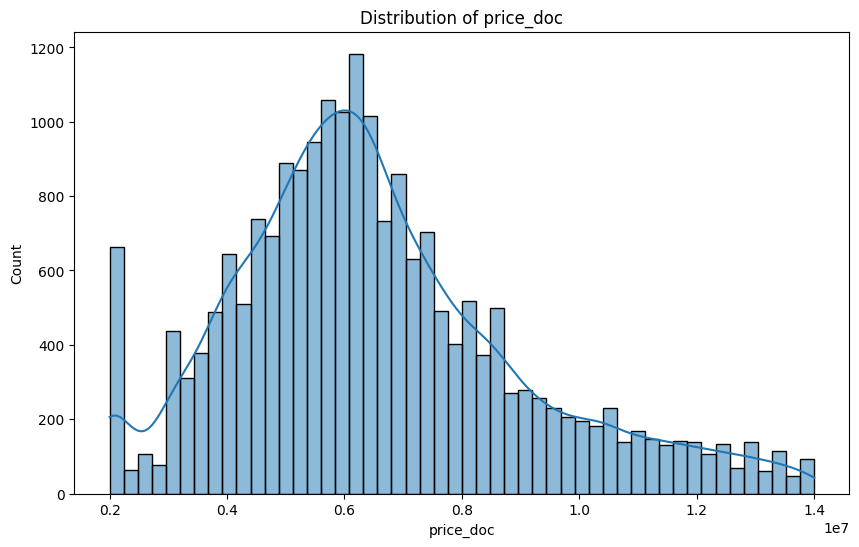

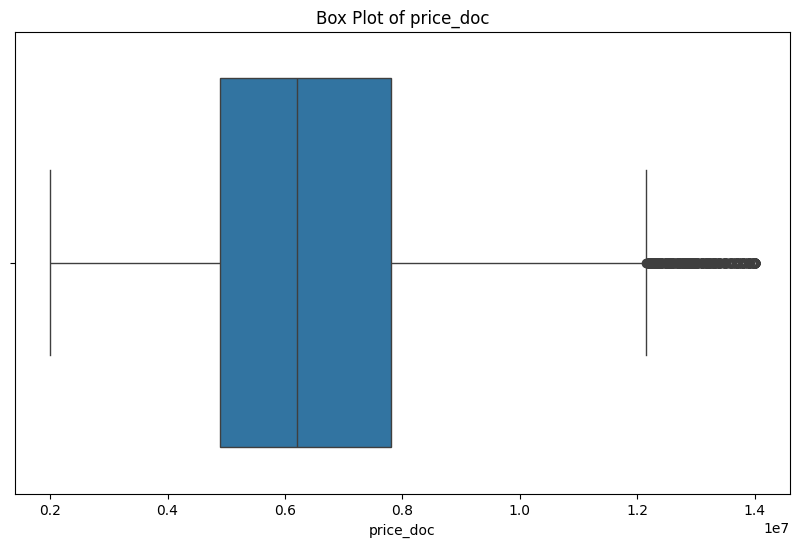

In [16]:
col_to_visualize = 'price_doc'
data_to_visualize = raw_data
data_to_visualize = data_with_outliers_removed
count_values_above_threshold(data_to_visualize, col_name=col_to_visualize)
count_values_below_threshold(data_to_visualize, col_to_visualize, 20)
visualize_target_distribution(data_to_visualize, col_to_visualize)

In [17]:
# data = Data_train
data = data_with_outliers_removed

X = data.drop(columns=[target_column])
y = data[target_column]

In [18]:
valeraInfo(X)

c:\programming\ml\Valera\utils\util.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
id,int64,20773,0,20773,100.000000
timestamp,datetime64[ns],1153,0,20773,100.000000
full_sq,int64,76,0,20773,100.000000
life_sq,float64,66,5014,15759,75.860000
floor,float64,23,95,20678,99.540000
max_floor,float64,30,6909,13864,66.740000
material,float64,6,6909,13864,66.740000
build_year,float64,88,10017,10756,51.780000
num_room,float64,6,6909,13864,66.740000
kitch_sq,float64,19,6909,13864,66.740000


In [19]:
df_cols = get_cols_containing(X, [
'university'
])
df_cols.head(1)

,university_top_20_raion,university_km
1,0,1.852560


In [20]:
df_cols = get_cols_containing(X, [
'full_all',
'male_f',
'female_f',
'young_all',
'young_male',
'young_female',
'work_all',
'work_male',
'work_female',
'ekder_all',
'ekder_male',
'ekder_female',
'0_6_all',
'0_6_male',
'0_6_female',
'7_14_all',
'7_14_male',
'7_14_female',
'0_17_all',
'0_17_male',
'0_17_female',
'16_29_all',
'16_29_male',
'16_29_female',
'0_13_all',
'0_13_male',
'0_13_female',
])
df_cols.head(1)


,full_all,male_f,female_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female
1,76284,34200,42084,42084,15727,7925,7802,70194,35622,34572,29431,9266,20165,6880,3466,3414,7759,3909,3850,17700,8998,8702,15164,7571,7593,13729,6929,6800


In [21]:
X = create_accessibility_and_adequacy_features(X)

X = process_and_drop_cafe_price_columns(X)
X = aggregate_affordability_accessibility(X)

X = process_distance_features(X, feature_distance_weights)

X['weighted_build_count'] = calculate_weighted_build_count(X, construction_weights)
X = drop_redundant_columns(X, 'build_count', construction_weights)
X = calculate_weighted_material_score(X, material_weights)

X = drop_redundant_columns(X, 'build_count', material_weights)

X = weighted_average_aggregation(X, 'green_part', green_weights)
X = weighted_average_aggregation(X, 'prom_part', prom_weights)

X = drop_redundant_columns(X, 'green_part', green_weights)
X = drop_redundant_columns(X, 'prom_part', prom_weights)

X = process_demographic_features(X)

X = improve_top_features(X, y)

X = drop_initial_features(X)

X = drop_testing(X)

In [22]:
# X = X.drop(columns=['ekder_male'], inplace=False)    

In [23]:
date_column = 'timestamp'
year_column = 'year_of_transaction'

X = X.copy()
X[date_column] = pd.to_datetime(X[date_column], errors='coerce')
X[year_column] = X[date_column].dt.year
X = X.drop(columns=[date_column])

In [24]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()

print(len(X.columns))
print(len(numerical_columns))
print(len(categorical_columns))

98
80
18


In [25]:
# numeric_cols_with_missing_values = [col for col in numerical_columns if X[col].isna().any()]
# print(len(numeric_cols_with_missing_values))

In [26]:
# Code block
binary_categories_columns = [binary_category_column] + boolean_category_columns
categorical_columns = [ecology_column] + binary_categories_columns + [sub_area_column]
all_columns = categorical_columns + numerical_columns
ecology_index = all_columns.index(ecology_column)

In [27]:
columns_for_numeric_knn_imputation = [col for col in all_columns if col != ecology_column]

preprocessing_pipeline = Pipeline([
    (
        'encoding',
        ColumnTransformer([
            (
                'ecology_ordinal', 
                OrdinalEncoder(
                    categories=[['poor', 'satisfactory', 'good', 'excellent']], 
                    handle_unknown='use_encoded_value', 
                    unknown_value=np.nan
                ), 
                [ecology_column]
            ),
            (
                'binary_ohe',
                OneHotEncoder(sparse_output=False, drop='if_binary'),
                binary_categories_columns
            ),
            (
                'sub_area_target',
                TargetEncoder(),
                [sub_area_column]
            ),
            (
                'numerical',
                'passthrough',
                numerical_columns
            )
        ])
    ),
    # ('scaling', StandardScaler()),
    # ('to_dataframe_after_scaling', DataFrameConverter(columns=all_columns)),
    # (
    #     'knn_imputation',
    #     ColumnTransformer([
    #         (
    #             'ecology',
    #             'passthrough',
    #             [ecology_column]
    #         ),
    #         (
    #             'knn_imputer',
    #             KNNImputer(n_neighbors=3),
    #             columns_for_numeric_knn_imputation
    #         )
    #     ])
    # ),
    # ('to_dataframe_after_knn_imputation', DataFrameConverter(columns=all_columns)),
    # (
    #     'ecology_imputation',
    #     ColumnTransformer(
    #         transformers=[(
    #             'knn_mode_imputer',
    #             KNNModeImputer(n_neighbors=3),
    #             [ecology_column]
    #         )],
    #         remainder='passthrough'
    #     )
    # )
])

In [28]:
X_processed = preprocessing_pipeline.fit_transform(X, y)

In [29]:
# processed_pipeline = preprocessing_pipeline.fit(X, y)
# X_scaled = processed_pipeline.transform(X)
X_scaled = undump_ZV('X_scaled_for_DBSCAN_all_features')

In [30]:
# X_copy = X.copy()  # Create a copy of the original features
# if 'price_doc' not in X.columns:
#     X_copy['price_doc'] = y 

# # Step 2: Scale the target independently
# target_scaler = StandardScaler()
# price_doc_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# # Combine scaled features and target
# X_scaled_combined = np.hstack([X_scaled, price_doc_scaled])

In [31]:
# # Step 1: Dimensionality Reduction with PCA
# n_components = 50  # Reduce to 50 dimensions
# pca = PCA(n_components=n_components)
# X_reduced = pca.fit_transform(X_scaled_combined)  # PCA-transformed dataset

# # Step 2: Apply DBSCAN in PCA Space
# dbscan = DBSCAN(eps=15, min_samples=60)  # Adjust based on k-distance plot
# labels = dbscan.fit_predict(X_reduced)

# # Step 3: Map Outliers Back to Original Dataset
# outlier_indices = np.where(labels == -1)[0]  # Indices of outliers
# outliers_original = X_copy.iloc[outlier_indices]  # Outliers in the original dataset

In [32]:
# # Selected top 20 features for analytics
# top_20_features = [
#     'price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
#     'kitch_sq', 'state', 'kremlin_km', 'metro_km_walk', 'park_km', 'school_km', 
#     'kindergarten_km', 'shopping_centers_km', 'green_zone_km', 'railroad_station_walk_km', 
#     'industrial_km', 'cafe_count_500', 'market_count_500'
# ]

# # Analyze Outliers with the Top 20 Features
# outliers_top_features = outliers_original[top_20_features]

# # Print Outliers Information
# print(f"Outliers detected: {len(outlier_indices)}")
# print("Sample Outliers in Original Dataset (Top 20 Features):")
# outliers_top_features.head()


In [33]:
# # Step 4: Visualize Outliers in Original Features
# plt.figure(figsize=(10, 6))
# plt.scatter(X_copy['price_doc'], X_copy['full_sq'], c='gray', s=10, label='Normal Points')
# plt.scatter(outliers_original['price_doc'], outliers_original['full_sq'], c='red', s=20, label='Outliers')
# plt.title("Outliers in Original Dataset")
# plt.xlabel("Price (price_doc)")
# plt.ylabel("Size (full_sq)")
# plt.legend()
# plt.show()

In [34]:
# # Step 1: Fit NearestNeighbors on the dataset
# k = 60  # min_samples value or a smaller heuristic (e.g., 2 * n_components)
# neighbors = NearestNeighbors(n_neighbors=k)
# neighbors_fit = neighbors.fit(X_reduced)  # Use PCA-reduced dataset
# distances, _ = neighbors_fit.kneighbors(X_reduced)

# # Step 2: Sort distances for the k-th neighbor
# distances = np.sort(distances[:, -1])  # Sort the k-th nearest neighbor distances

# # Step 3: Plot the k-Distance Graph
# plt.figure(figsize=(10, 6))
# plt.plot(distances)
# plt.title("k-Distance Plot")
# plt.xlabel("Data Point Index (sorted)")
# plt.ylabel(f"{k}-Distance")
# plt.grid()
# plt.show()


In [35]:
# raise ValueError("This is a custom error message")

In [36]:
reduced_features = ['sub_area', 'num_room', 'raion_build_count_with_material_info', 'full_sq', 'elderly_healthcare_accessibility', 'life_sq', 'sport_count_weighted', 'cafe_total_affordability', 'office_sqm_weighted', 'kitch_sq', 'trc_count_weighted', 'cafe_total_accessibility', 'build_year', 'raion_build_count_with_builddate_info', 'product_type']
reduced_features_ordered = [col for col in all_columns if col in reduced_features]

In [37]:
feature_columns = reduced_features_ordered
feature_columns = all_columns

In [38]:
# Convert X_processed to a DataFrame if it's in NumPy format
X_processed_df = pd.DataFrame(X_processed, columns=all_columns)  # `all_columns` should be your original list of column names

# Filter the DataFrame to include only the reduced set of features
X_reduced_df = X_processed_df[feature_columns]

# If you need it back as a NumPy array, convert it here
X_reduced = X_reduced_df.to_numpy()

In [39]:
X_split = X_reduced
print(X_split.shape[1])
print(X_split.shape[0])

95
20773


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_split, y, test_size=0.2, random_state=42)

In [41]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

In [42]:
# Cross-validated predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate cross-validated metrics
cv_mse = mean_squared_error(y_train, cv_predictions)
cv_rmse = np.sqrt(cv_mse)
cv_r2 = r2_score(y_train, cv_predictions)

# Calculate LRMSE for cross-validation
cv_lrmse = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(cv_predictions)))

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Cross-Validated R^2 Score: {cv_r2}")
print(f"Cross-Validated LRMSE: {cv_lrmse}")

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = model.predict(X_test)

# Calculate test metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

# Calculate LRMSE for the test set
test_lrmse = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(test_predictions)))

print(f"Test RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")
print(f"Test LRMSE: {test_lrmse}")

Cross-Validated RMSE: 1556353.177977883
Cross-Validated R^2 Score: 0.6045137643814087
Cross-Validated LRMSE: 0.29071727241883993
Test RMSE: 1477194.8309222492
Test R^2 Score: 0.6460800170898438
Test LRMSE: 0.26547849332856366


In [43]:
# Assuming X_test is preprocessed and ready for predictions
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_test, y_pred)

print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

Mean Squared Logarithmic Error (MSLE): 0.07047883042000423


In [44]:
model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

In [45]:
print(len(X_test))
print(len(y_test))
print(len(X_split))
print(len(y))

4155
4155
20773
20773


In [46]:
model_fi.fit(X_train, y_train)
importances = model_fi.feature_importances_
len(importances)

95

In [47]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.index = range(1, len(feature_importance_df) + 1)
feature_importance_df.index.name = 'Rank'

print(feature_importance_df)

                                    Feature  Importance
Rank                                                   
1                             sub_area_mean    0.169981
2                               log_full_sq    0.109332
3                                  sub_area    0.081520
4                                   full_sq    0.044979
5                                   life_sq    0.020758
6                  cafe_total_affordability    0.018392
7                              building_age    0.018295
8                  cafe_total_accessibility    0.013069
9                          full_sq_per_room    0.011643
10                     weighted_build_count    0.011059
11                               build_year    0.010344
12                      office_sqm_weighted    0.010213
13                    city_center_proximity    0.009776
14           cafe_affordability_per_density    0.009729
15                            working_ratio    0.009669
16                                 kitch_sq    0

In [48]:
raise ValueError("This is a custom error message")

ValueError: This is a custom error message

In [ ]:
importance_threshold = 0.01
features_all = feature_importance_df['Feature'].tolist()
features_to_keep = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()
print(len(features_to_keep))
print(len(features_all))

In [ ]:
# Check features that are being kept and dropped based on the threshold
features_below_threshold = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]
features_above_threshold = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]

print("Number of features below threshold:", len(features_below_threshold))
print("Number of features above threshold:", len(features_above_threshold))

# Display the list of features below the threshold to inspect
# print("Features below the threshold of importance:")
# print(features_below_threshold[['Feature', 'Importance']].sort_values(by='Importance', ascending=True))

features_to_keep = features_above_threshold['Feature'].tolist()
print("Features to keep (for hard-coding):")
print(features_to_keep)



# To verify the exact number of features to drop
features_to_drop = features_below_threshold['Feature'].tolist()
print(f"Number of features to drop: {len(features_to_drop)}")
